In [1]:
# Imports (numpy, pandas, matplotlib, seaborn imported automatically)
import requests
from etherscan import Etherscan
from BondingCurveNexus import config, sys_params
from BondingCurveNexus.param_functions import open_liq, wnxm_movement_per_eth
from BondingCurveNexus.sys_class import NexusSystem
from scipy.stats import lognorm
from tqdm import tqdm
from random import shuffle

In [2]:
# activate etherscan client
eth_client = Etherscan(config.etherscan_api)
eth_price_usd = float(eth_client.get_eth_last_price()['ethusd'])
eth_price_usd

1297.29

In [3]:
supply_url = 'https://api.coingecko.com/api/v3/coins/wrapped-nxm'
wnxm_supply_now = requests.get(supply_url).json()['market_data']['total_supply']
wnxm_supply_now

2932364.39981012

In [4]:
system_instance = NexusSystem(liquidity_eth=open_liq(0.5), wnxm_move_size=wnxm_movement_per_eth(500_000))

In [5]:
sys_params.wnxm_price_now / system_instance.book_value()

0.5479557363836165

# Dutch Auction Modelling

## Dutch Auction Mechanism

Assume that we start at wNXM, as new tokenomics will start slightly below; therefore the first "interesting point" will be when the ratchet hits wNXM price.

Mechanisms:
1. Uniswap v2 Curve to push price up when buys happen & down when sales happen
2. Two-sided market above book with a x% penalty for sales
3. Buys disabled below book and price discovery through ratchet mechanism

Floor at book value for buys - we don't want to allow people to buy for less than BV to avoid dilution with cheap NXM. However, to allow price to go up we also must allow sells above BV.

### Liquidity parameters

Current proposed approach to liquidity: 
- have a large opening liquidity that allows us to get to book value while draining wNXM markets (tens of thousands of ETH)
- have a low target liquidity (<5k ETH) that liquidity approaches over time
- increase liquidity towards target below BV and decrease liquidity above BV towards target, but not the other way around

In [11]:
# opening liquidity provided
opening_liq = 25_000
# target liquidity
liq_target = 2500
# percentage of target per day that liquidity moves (additively) towards target
liq_move_perc = 0.02
# number of daily liquidity moves
daily_liq_moves = 5

### Ratchet sizing

Ratchet speed, for consistency, should be defined in relation to book value price. This enables a linear climb towards book value instead of a percentage or fixed number of NXM liquidity.

Also defining how many times this happens per day so that the ascent can be a bit smoother in the modelling. In practice, hopefully the ratchet is streamed.

Process inside system class:
- Define percentage x% of book value that increases on a daily basis as system parameter
- Use current book value to define x% in NXM price terms
- Solve for new NXM liquidity

In [14]:
ratchet_bv_perc = 0.04
ratchets_per_day = 5

### Buy/sell spread

Price difference between buys & sells.

- adds an x% bonus to buyers where users wishing to provide a worth of ETH will actually receive (1+x%) * a worth of NXM
- this will not impact ETH amounts in the Uni market, but instead add extra NXM

In [15]:
spread = 0.02

### wNXM Liquidity in Open Market

Obtained from https://www.coingecko.com/en/coins/wrapped-nxm#markets, summed +2% and -2% depth across all exchanges & averaged the two. Rounded to nearest 10k (last 05/10/2022)

Average is about 260k, but typically using 500k which assumes that liquidity is higher at higher prices. Crude, to be improved.

Function converts 2%-move USD liquidity to an absolute ETH value move per 1 ETH sold/bought on open market. This ETH value only depends on current wNXM price and not on the wNXM price at the time.

In [16]:
wnxm_move_size = wnxm_movement_per_eth(two_perc_liq_usd=500_000)
wnxm_move_size

6.4518219608e-07

In [17]:
# How a wNXM buy works:
# establish current price
wnxm_open_price = sys_params.wnxm_price_now
# establish number of wNXM bought
n_wnxm = 50000
# translate amount to ETH
n_eth = n_wnxm * wnxm_open_price
# establish closing price
wnxm_close_price = wnxm_open_price + n_eth * wnxm_movement_per_eth(250_000)
print(wnxm_open_price, n_eth, wnxm_close_price, wnxm_close_price/wnxm_open_price - 1)

0.0124213 621.0649999999999 0.01322270016121685 0.06451821960799986


### NXM buy/sell sizing - Lognormal

lognormal distribution of size of a typical entry and exit in ETH

parameterised to median value being ~1 ETH, upper quartile ~4 ETH

In [18]:
entry_shape = 2
entry_loc = 0
entry_scale = 1

exit_shape = 2
exit_loc = 0
exit_scale = 1

In [19]:
pd.DataFrame(lognorm.rvs(s=exit_shape, loc=exit_loc, scale=exit_scale, size=10_000)).describe()

,0
count,10000.000000
mean,7.440101
std,40.716510
min,0.000325
25%,0.262419
50%,1.012410
75%,3.937713
max,2575.934087


### NXM buy/sell sizing - Deterministic

To be able to properly assess the differences between individual runs, we may want to have deterministic buy & sell pressure within and outside the platform.

Size is mean of lognormal, so about 7.5 ETH.

In [20]:
det_sell_size = 7.5

### NXM buys/sells from platform per day

Poisson distribution of number of entries & exits per day.

Lambda parameters can also be used as deterministic numbers for runs.

In [21]:
lambda_entries = 5
lambda_exits = 5

In [22]:
pd.DataFrame(np.random.poisson(lam=lambda_entries, size=10_000)).describe()

,0
count,10000.00000
mean,4.99840
std,2.25719
min,0.00000
25%,3.00000
50%,5.00000
75%,6.00000
max,16.00000


### wNXM drift & diffusion

Relative % change in wNXM price on open market due to random fluctuations based on a normal distribution

In [23]:
wnxm_shifts_per_day = 5
wnxm_drift = 0
wnxm_diffusion = (1+0.02)**(1/wnxm_shifts_per_day) - 1

In [24]:
wnxm_diffusion

0.003968378704429121

## Uniswap v2 OOP Classes - Double-sided above BV

1. UniPool - base class (single opening liquidity)

2. UniPoolLiq - class with separate opening and target liquidities & movement towards target

3. UniPoolStoch - subclass of 1. that runs stochastically
4. UniPoolDet - subclass of 1. that runs deterministically

5. UniPoolLiqStoch - subclass of 2. that runs stochastically
6. UniPoolLiqDet - subclass of 2. that runs deterministically

In [28]:
# Create class with specified initial liquidity & wnxm parameters

class UniPool:
    # initial parameters
    def __init__(self, liquidity_eth, wnxm_price, wnxm_move_size):
        # start at day 0
        self.current_day = 0
        
        # set wNXM and NXM supply, Capital Pool
        self.nxm_supply = system_instance.nxm_supply
        self.wnxm_supply = wnxm_supply_now
        self.cap_pool = system_instance.cap_pool
        
        # set initial wNXM price
        self.wnxm_price = wnxm_price      
        # set initial ETH liquidity
        self.liquidity_eth = liquidity_eth
        
        # set change in wnxm price per 1 ETH of wnxm bought/sold
        self.wnxm_move_size = wnxm_move_size
        
        # set buy/sell spread above BV
        self.spread = spread
        
        # set initial NXM liquidity based on opening wNXM price
        # assume that prices have converged after initial period
        self.liquidity_nxm = self.liquidity_eth / self.wnxm_price
        
        # set intial invariant 
        self.invariant = self.liquidity_eth * self.liquidity_nxm
        
        # base entries and exits - set stochasically or deterministically in subclasses
        self.base_daily_platform_buys = np.zeros(shape=model_days, dtype=int)
        self.base_daily_platform_sales = np.zeros(shape=model_days, dtype=int)
        
        # set cumulative parameters to 0
        self.eth_sold = 0
        self.eth_acquired = 0
        self.nxm_burned = 0
        self.nxm_minted = 0
        self.wnxm_removed = 0
        self.wnxm_created = 0
        
        # set tracking lists for individual instance
        self.cap_pool_prediction = [self.cap_pool]
        self.nxm_price_prediction = [self.nxm_price(action='sale')]
        self.wnxm_price_prediction = [self.wnxm_price]
        self.nxm_supply_prediction = [self.nxm_supply]
        self.wnxm_supply_prediction = [self.wnxm_supply]
        self.book_value_prediction = [self.book_value()]
        self.liquidity_nxm_prediction = [self.liquidity_nxm]
        self.liquidity_eth_prediction = [self.liquidity_eth]
        self.eth_sold_prediction = [self.eth_sold]
        self.eth_acquired_prediction = [self.eth_acquired]
        self.nxm_burned_prediction = [self.nxm_burned]
        self.nxm_minted_prediction = [self.nxm_minted]
        self.wnxm_removed_prediction = [self.wnxm_removed]
        self.wnxm_created_prediction = [self.wnxm_created]
        
        
    # system nxm price expressed in ETH
    def book_value(self):
        if self.nxm_supply == 0:
            return 0
        return self.cap_pool/self.nxm_supply
    
    def nxm_price(self, action):
        # apply spread to buys    
        if action == 'buy':
            return self.liquidity_eth / (self.liquidity_nxm * (1 - self.spread))
        # otherwise return price without spread
        return self.liquidity_eth / self.liquidity_nxm
    
    def nxm_sale_size(self):
        # defined in subclasses - can be stochastic or deterministic 
        return 0
        
    # one sale of n_nxm NXM
    def platform_nxm_sale(self, n_nxm):
        # limit number to total NXM
        n_nxm = min(n_nxm, self.nxm_supply)
        
        # add sold NXM to pool
        self.liquidity_nxm += n_nxm
        self.nxm_supply -= n_nxm
        
        # establish new value of eth in pool
        new_eth = self.invariant / self.liquidity_nxm
        delta_eth = self.liquidity_eth - new_eth
        
        # add ETH removed and nxm burned to cumulative total, update capital pool
        self.eth_sold += delta_eth
        self.cap_pool -= delta_eth
        self.nxm_burned += n_nxm
        
        # update ETH liquidity & invariant (which will change due to spread)
        self.liquidity_eth = new_eth
        self.invariant = self.liquidity_eth * self.liquidity_nxm
        
    # one buy of n_nxm NXM, allowing for spread
    def platform_nxm_buy(self, n_nxm):
        # remove bought NXM from pool (with spread) and add actual mint to supply
        self.liquidity_nxm -= n_nxm * (1 + self.spread)
        self.nxm_supply += n_nxm
        
        # establish new value of eth in pool
        new_eth = self.invariant / self.liquidity_nxm
        delta_eth = new_eth - self.liquidity_eth
        
        # add ETH acquired and nxm minted to cumulative total, update capital pool
        self.eth_acquired += delta_eth
        self.cap_pool += delta_eth
        self.nxm_minted += n_nxm
        
        # update ETH liquidity
        self.liquidity_eth = new_eth
    
    def wnxm_market_buy(self, n_wnxm, arb=True):
        # limit number of wnxm bought to total supply
        n_wnxm = min(n_wnxm, self.wnxm_supply)
        
        # crude calc for ETH amount (assuming whole buy happens on opening price)
        n_eth = n_wnxm * self.wnxm_price
        
        # increase price depending on defined liquidity parameters
        self.wnxm_price += n_eth * self.wnxm_move_size
        
        # if used for arb, remove from supply
        if arb:
            self.wnxm_supply -= n_wnxm
            self.wnxm_removed += n_wnxm
    
    def wnxm_market_sell(self, n_wnxm, arb=True):
        # limit number of wnxm sold to total supply
        n_wnxm = min(n_wnxm, self.wnxm_supply)
        
        # crude calc for ETH amount (assuming whole sell happens on opening price)
        n_eth = n_wnxm * self.wnxm_price
        
        # decrease price depending on defined liquidity parameters
        self.wnxm_price -= n_eth * self.wnxm_move_size
        
        # if used for arb, add to supply
        if arb:
            self.wnxm_supply += n_wnxm
            self.wnxm_created += n_wnxm
    
    def arb_sale_transaction(self):
        # establish size of nxm sell
        num = self.nxm_sale_size()
        # buy from open market
        self.wnxm_market_buy(n_wnxm=num, arb=True)
        # sell to platform
        self.platform_nxm_sale(n_nxm=num)
        
    def arb_buy_transaction(self):
        # establish size of nxm buy
        num = self.nxm_sale_size()
        # buy from platform
        self.platform_nxm_buy(n_nxm=num)
        # sell to open market
        self.wnxm_market_sell(n_wnxm=num, arb=True)
    
    def ratchet_up(self): 
        # establish price movement required to be relevant percentage of BV
        price_movement = self.book_value() * ratchet_bv_perc / ratchets_per_day
        
        # establish target price and cap at book value
        target_price = min(self.nxm_price(action='sale') + price_movement, self.book_value())
        
        # update NXM liquidity to reflect new price
        self.liquidity_nxm = self.liquidity_eth / target_price
        
        # update invariant
        self.invariant = self.liquidity_eth * self.liquidity_nxm
    
    def wnxm_shift(self):
        # defined in subclasses - can be stochastic or deterministic 
        self.wnxm_price *= 1
        
    def one_day_passes(self):
        # create list of events and shuffle it
        events_today = []
        events_today.extend(['ratchet'] * ratchets_per_day)
        events_today.extend(['wnxm_shift'] * wnxm_shifts_per_day)
        events_today.extend(['platform_buy'] * self.base_daily_platform_buys[self.current_day])
        events_today.extend(['platform_sale'] * self.base_daily_platform_sales[self.current_day])
        shuffle(events_today)

        # LOOP THROUGH EVENTS OF DAY
        for event in events_today:
            
            #-----WNXM ARBITRAGE-----#
            # happens in between all events
            while self.nxm_price(action='sale') > self.wnxm_price:
                self.arb_sale_transaction()
            while self.nxm_price(action='buy') > self.book_value() and\
            self.nxm_price(action='buy') < self.wnxm_price:
                self.arb_buy_transaction()

            #-----RATCHET-----#
            if event == 'ratchet':
                # up if below BV
                if self.book_value() > self.nxm_price(action='sale'):
                    self.ratchet_up()

            #-----WNXM SHIFT-----#
            if event == 'wnxm_shift':
                self.wnxm_shift()

            #-----PLATFORM BUY-----#
            # not arbitrage-driven
            if event == 'platform_buy':
                # doesn't happen if wnxm price is below platform price or
                # platform price is below book value
                # instead buy wNXM (with no arb)
                if self.nxm_price(action='buy') > self.wnxm_price or\
                self.nxm_price(action='buy') < self.book_value():
                    self.wnxm_market_buy(n_wnxm=self.nxm_sale_size(), arb=False)

                # otherwise execute the buy
                self.platform_nxm_buy(n_nxm=self.nxm_sale_size())

            #-----PLATFORM SALE-----#
            # not arbitrage-driven
            if event == 'platform_sale':
                # doesn't happen if wnxm price is above platform price
                # instead sell wNXM on open market (no arb)
                if self.nxm_price(action='sale') < self.wnxm_price:
                    self.wnxm_market_sell(n_wnxm=self.nxm_sale_size(), arb=False)

                # otherwise execute the sell
                self.platform_nxm_sale(n_nxm=self.nxm_sale_size())
        
        # append values to tracking metrics
        self.cap_pool_prediction.append(self.cap_pool)
        self.nxm_price_prediction.append(self.nxm_price(action='sale'))
        self.wnxm_price_prediction.append(self.wnxm_price)
        self.nxm_supply_prediction.append(self.nxm_supply)
        self.wnxm_supply_prediction.append(self.wnxm_supply)
        self.book_value_prediction.append(self.book_value())
        self.liquidity_nxm_prediction.append(self.liquidity_nxm)
        self.liquidity_eth_prediction.append(self.liquidity_eth)
        self.eth_sold_prediction.append(self.eth_sold)
        self.eth_acquired_prediction.append(self.eth_acquired)
        self.nxm_burned_prediction.append(self.nxm_burned)
        self.nxm_minted_prediction.append(self.nxm_minted)
        self.wnxm_removed_prediction.append(self.wnxm_removed)
        self.wnxm_created_prediction.append(self.wnxm_created)
        
        # increment day
        self.current_day += 1

In [36]:
# create class with opening and target liquidity
# increase liquidity towards target below BV and reduce liquidity towards target above BV

class UniPoolLiq(UniPool):
    def __init__(self, open_liq, target_liq, wnxm_price, wnxm_move_size):
        
        # initialise all the same stuff as UniPool
        super().__init__(liquidity_eth, wnxm_price, wnxm_move_size)
        
        # set daily liquidity limit
        self.liquidity_eth = open_liq
        self.target_liq = target_liq
        
    def liq_move(self, new_liq)
        # solve for required NXM liquidity first without changing price
        self.liquidity_nxm = new_liq / self.nxm_price(action='sale')
        
        # update ETH liquidity
        self.liquidity_eth = new_liq
        
        # update invariant
        self.invariant = self.liquidity_nxm * self.liquidity_eth
        
    def new_liq(self):
        # move ETH liquidity towards target
        # if above book & above target liq, down to target at daily percentage rate
        # divided by number of times we're moving liquidity per day
        if self.nxm_price(action='sale') > self.book_value() and\
            self.liquidity_eth > self.target_liq:
            return max(self.liquidity_eth - self.target_liq * liq_move_perc / daily_liq_moves)
        
#######---------------PICK UP HERE--------------######
    
    def one_day_passes(self):
        # create list of events and shuffle it
        events_today = []
        events_today.extend(['ratchet'] * ratchets_per_day)
        events_today.extend(['wnxm_shift'] * wnxm_shifts_per_day)
        events_today.extend(['platform_buy'] * self.base_daily_platform_buys[self.current_day])
        events_today.extend(['platform_sale'] * self.base_daily_platform_sales[self.current_day])
        events_today
        shuffle(events_today)

        # LOOP THROUGH EVENTS OF DAY
        for event in events_today:
            
            #-----WNXM ARBITRAGE-----#
            # happens in between all events
            while self.nxm_price(action='sale') > self.wnxm_price:
                self.arb_sale_transaction()
            while self.nxm_price(action='buy') > self.book_value() and\
            self.nxm_price(action='buy') < self.wnxm_price:
                self.arb_buy_transaction()

            #-----RATCHET-----#
            if event == 'ratchet':
                # up if below BV
                if self.book_value() > self.nxm_price(action='sale'):
                    self.ratchet_up()

            #-----LIQUIDITY MOVE-----#
            if event == 'ratchet':
                # up if below BV
                if self.book_value() > self.nxm_price(action='sale'):
                    self.ratchet_up()
                    
            #-----WNXM SHIFT-----#
            if event == 'wnxm_shift':
                self.wnxm_shift()

            #-----PLATFORM BUY-----#
            # not arbitrage-driven
            if event == 'platform_buy':
                # doesn't happen if wnxm price is below platform price or
                # platform price is below book value
                # instead buy wNXM (with no arb)
                if self.nxm_price(action='buy') > self.wnxm_price or\
                self.nxm_price(action='buy') < self.book_value():
                    self.wnxm_market_buy(n_wnxm=self.nxm_sale_size(), arb=False)

                # otherwise execute the buy
                self.platform_nxm_buy(n_nxm=self.nxm_sale_size())

            #-----PLATFORM SALE-----#
            # not arbitrage-driven
            if event == 'platform_sale':
                # doesn't happen if wnxm price is above platform price
                # instead sell wNXM on open market (no arb)
                if self.nxm_price(action='sale') < self.wnxm_price:
                    self.wnxm_market_sell(n_wnxm=self.nxm_sale_size(), arb=False)

                # otherwise execute the sell
                self.platform_nxm_sale(n_nxm=self.nxm_sale_size())
        
        # append values to tracking metrics
        self.cap_pool_prediction.append(self.cap_pool)
        self.nxm_price_prediction.append(self.nxm_price(action='sale'))
        self.wnxm_price_prediction.append(self.wnxm_price)
        self.nxm_supply_prediction.append(self.nxm_supply)
        self.wnxm_supply_prediction.append(self.wnxm_supply)
        self.book_value_prediction.append(self.book_value())
        self.liquidity_nxm_prediction.append(self.liquidity_nxm)
        self.liquidity_eth_prediction.append(self.liquidity_eth)
        self.eth_sold_prediction.append(self.eth_sold)
        self.eth_acquired_prediction.append(self.eth_acquired)
        self.nxm_burned_prediction.append(self.nxm_burned)
        self.nxm_minted_prediction.append(self.nxm_minted)
        self.wnxm_removed_prediction.append(self.wnxm_removed)
        self.wnxm_created_prediction.append(self.wnxm_created)
        
        # increment day
        self.current_day += 1

In [37]:
# stochastic subclasses

class UniPoolStoch(UniPool):
    def __init__(self, liquidity_eth, wnxm_price, wnxm_move_size):
        
        # initialise all the same stuff as UniPool
        super().__init__(liquidity_eth, wnxm_price, wnxm_move_size)
        
        # base entries and exits using a poisson distribution
        self.base_daily_platform_buys = np.random.poisson(
                                                lam=lambda_entries,
                                                size=model_days)
        self.base_daily_platform_sales = np.random.poisson(
                                                lam=lambda_exits,
                                                size=model_days)
    
    def nxm_sale_size(self):
        # lognormal distribution of nxm sales
        return lognorm.rvs(s=exit_shape, loc=exit_loc, scale=exit_scale) / self.nxm_price(action='sale')
    
    def wnxm_shift(self):
        # set percentage changes in wnxm price using a normal distribution
        self.wnxm_price *= (1 + np.random.normal(loc=wnxm_drift, scale=wnxm_diffusion))
        
class UniPoolStochRenew(UniPoolRenew):
    def __init__(self, liquidity_eth, wnxm_price, wnxm_move_size):
        
        # initialise all the same stuff as UniPool
        super().__init__(liquidity_eth, wnxm_price, wnxm_move_size)
        
        # base entries and exits using a poisson distribution
        self.base_daily_platform_buys = np.random.poisson(
                                                lam=lambda_entries,
                                                size=model_days)
        self.base_daily_platform_sales = np.random.poisson(
                                                lam=lambda_exits,
                                                size=model_days)
    
    def nxm_sale_size(self):
        # lognormal distribution of nxm sales
        return lognorm.rvs(s=exit_shape, loc=exit_loc, scale=exit_scale) / self.nxm_price(action='sale')
    
    def wnxm_shift(self):
        # set percentage changes in wnxm price using a normal distribution
        self.wnxm_price *= (1 + np.random.normal(loc=wnxm_drift, scale=wnxm_diffusion))

In [38]:
# deterministic subclass (but including wNXM randomness)

class UniPoolDet(UniPool):
    def __init__(self, liquidity_eth, wnxm_price, wnxm_move_size):
        
        # initialise all the same stuff as UniPool
        super().__init__(liquidity_eth, wnxm_price, wnxm_move_size)
        
        # base entries and exits using a poisson distribution
        self.base_daily_platform_buys = np.full(shape=model_days, fill_value=lambda_entries, dtype=int)
        self.base_daily_platform_sales = np.full(shape=model_days, fill_value=lambda_exits, dtype=int)
    
    def nxm_sale_size(self):
        # lognormal distribution of nxm sales
        return det_sell_size / self.nxm_price(action='sale')
    
    def wnxm_shift(self):
        # set percentage changes in wnxm price
        self.wnxm_price *= 1
        
class UniPoolDetRenew(UniPoolRenew):
    def __init__(self, liquidity_eth, wnxm_price, wnxm_move_size):
        
        # initialise all the same stuff as UniPool
        super().__init__(liquidity_eth, wnxm_price, wnxm_move_size)
        
        # base entries and exits using a poisson distribution
        self.base_daily_platform_buys = np.full(shape=model_days, fill_value=lambda_entries, dtype=int)
        self.base_daily_platform_sales = np.full(shape=model_days, fill_value=lambda_exits, dtype=int)
    
    def nxm_sale_size(self):
        # lognormal distribution of nxm sales
        return det_sell_size / self.nxm_price(action='sale')
    
    def wnxm_shift(self):
        # set percentage changes in wnxm price
        self.wnxm_price *= 1

## Runs

### Set up Single Simulation

100%|████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [00:00<00:00, 7160.33it/s]


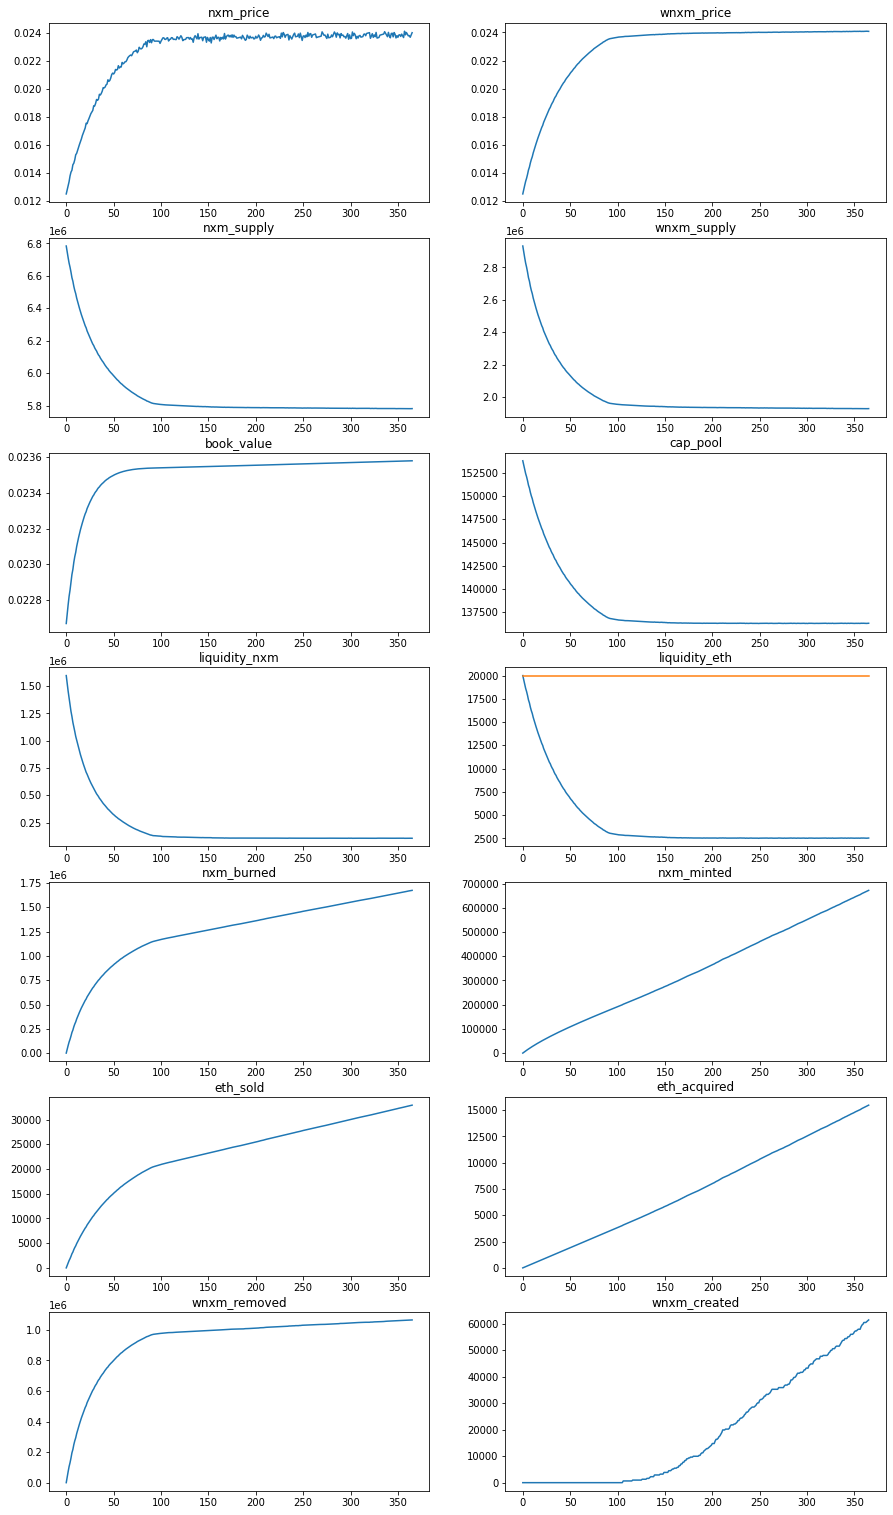

In [53]:
# model days
model_days = 365

# opening liquidity
liquidity_eth = 20_000

# amount of USD it takes to make a 2% change in NXM price
wnxm_move_size = wnxm_movement_per_eth(two_perc_liq_usd=500_000)
# opening NXM price
wnxm_price = sys_params.wnxm_price_now

# number of entries & exits per day
lambda_entries = 5
lambda_exits = 5

# lognormal dist of size of entries and exits
entry_shape = 2
entry_loc = 0
entry_scale = 1
exit_shape = 2
exit_loc = 0
exit_scale = 1

# deterministic entry & exit size
det_sell_size = 7.5

sim = UniPoolDet(liquidity_eth=liquidity_eth, wnxm_price=wnxm_price, wnxm_move_size=wnxm_move_size)
days_run = 0

for i in tqdm(range(model_days)):
    try:
        sim.one_day_passes()
        days_run += 1
    except ZeroDivisionError:
        print('Something went to Zero!')
        break
    
    
#-----GRAPHS-----#
# Destructuring initialization
fig, axs = plt.subplots(7, 2, figsize=(15,27)) # axs is a (7,2) nd-array

# Subplot
axs[0, 0].plot(range(days_run+1), sim.nxm_price_prediction)
axs[0, 0].set_title('nxm_price')
# Subplot
axs[0, 1].plot(range(days_run+1), sim.wnxm_price_prediction)
axs[0, 1].set_title('wnxm_price')
# Subplot
axs[1, 0].plot(range(days_run+1), sim.nxm_supply_prediction)
axs[1, 0].set_title('nxm_supply')
# Subplot
axs[1, 1].plot(range(days_run+1), sim.wnxm_supply_prediction)
axs[1, 1].set_title('wnxm_supply')
# Subplot
axs[2, 0].plot(range(days_run+1), sim.book_value_prediction)
axs[2, 0].set_title('book_value')
# Subplot
axs[2, 1].plot(range(days_run+1), sim.cap_pool_prediction)
axs[2, 1].set_title('cap_pool')
# Subplot
axs[3, 0].plot(range(days_run+1), sim.liquidity_nxm_prediction)
axs[3, 0].set_title('liquidity_nxm')
# Subplot
axs[3, 1].plot(range(days_run+1), sim.liquidity_eth_prediction)
axs[3, 1].plot(range(days_run+1), np.full(shape=days_run+1, fill_value=liquidity_eth))
axs[3, 1].set_title('liquidity_eth')
# Subplot
axs[4, 0].plot(range(days_run+1), sim.nxm_burned_prediction)
axs[4, 0].set_title('nxm_burned')
# Subplot
axs[4, 1].plot(range(days_run+1), sim.nxm_minted_prediction)
axs[4, 1].set_title('nxm_minted')
# Subplot
axs[5, 0].plot(range(days_run+1), sim.eth_sold_prediction)
axs[5, 0].set_title('eth_sold')
# Subplot
axs[5, 1].plot(range(days_run+1), sim.eth_acquired_prediction)
axs[5, 1].set_title('eth_acquired')
# Subplot
axs[6, 0].plot(range(days_run+1), sim.wnxm_removed_prediction)
axs[6, 0].set_title('wnxm_removed')
# Subplot
axs[6, 1].plot(range(days_run+1), sim.wnxm_created_prediction)
axs[6, 1].set_title('wnxm_created')

plt.show()

In [26]:
sim.liquidity_eth

48.440565140610644

### wNXM liquidity in markets

We test a range of available wNXM liquidity in markets. At current prices, according to coingecko, a 2% shift occurs approximately at $250k sold/bought. Likely that more market sellers will be available at higher prices, so most alternative liquidity parameter tests are explored upwards.

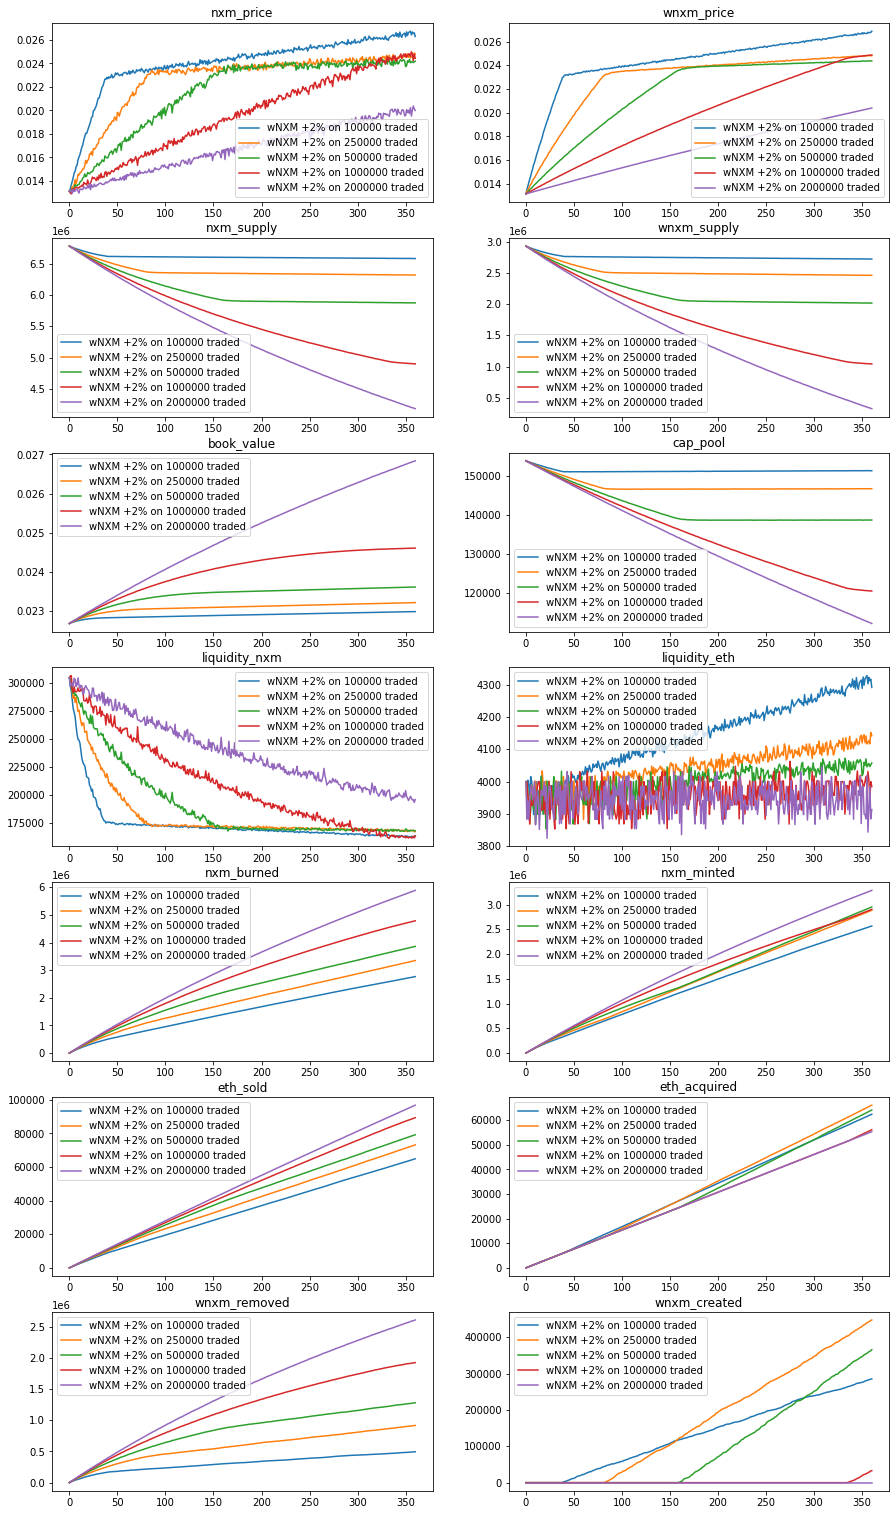

In [33]:
# model days
model_days = 360

# opening liquidity
liquidity_eth = 4_000

# amount of USD it takes to make a 2% change in NXM price
# wnxm_move_size = wnxm_movement_per_eth(two_perc_liq_usd=500_000)
# opening NXM price
wnxm_price = sys_params.wnxm_price_now

# number of entries & exits per day
lambda_entries = 10
lambda_exits = 10

# lognormal dist of size of entries and exits
entry_shape = 2
entry_loc = 0
entry_scale = 1
exit_shape = 2
exit_loc = 0
exit_scale = 1

# deterministic entry & exit size
det_sell_size = 15

wnxm_liq_range_usd = [100_000, 250_000, 500_000, 1_000_000, 2_000_000]

sims = [UniPoolDet(liquidity_eth=liquidity_eth, wnxm_price=wnxm_price, wnxm_move_size=wnxm_movement_per_eth(liq))
        for liq in wnxm_liq_range_usd]

for sim in sims:
    for i in range(model_days):
        try:
            sim.one_day_passes()
            days_run += 1
        except ZeroDivisionError:
            print('Something went to Zero!')
            break  

#-----GRAPHS-----#
# Destructuring initialization
fig, axs = plt.subplots(7, 2, figsize=(15,27)) # axs is a (6,2) nd-array
# Subplot
for i in range(len(sims)):
    axs[0, 0].plot(range(model_days+1), sims[i].nxm_price_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[0, 0].set_title('nxm_price')
axs[0, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[0, 1].plot(range(model_days+1), sims[i].wnxm_price_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[0, 1].set_title('wnxm_price')
axs[0, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 0].plot(range(model_days+1), sims[i].nxm_supply_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[1, 0].set_title('nxm_supply')
axs[1, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 1].plot(range(model_days+1), sims[i].wnxm_supply_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[1, 1].set_title('wnxm_supply')
axs[1, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 0].plot(range(model_days+1), sims[i].book_value_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[2, 0].set_title('book_value')
axs[2, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 1].plot(range(model_days+1), sims[i].cap_pool_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[2, 1].set_title('cap_pool')
axs[2, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 0].plot(range(model_days+1), sims[i].liquidity_nxm_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[3, 0].set_title('liquidity_nxm')
axs[3, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 1].plot(range(model_days+1), sims[i].liquidity_eth_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[3, 1].set_title('liquidity_eth')
axs[3, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[4, 0].plot(range(model_days+1), sims[i].nxm_burned_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[4, 0].set_title('nxm_burned')
axs[4, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[4, 1].plot(range(model_days+1), sims[i].nxm_minted_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[4, 1].set_title('nxm_minted')
axs[4, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[5, 0].plot(range(model_days+1), sims[i].eth_sold_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[5, 0].set_title('eth_sold')
axs[5, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[5, 1].plot(range(model_days+1), sims[i].eth_acquired_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[5, 1].set_title('eth_acquired')
axs[5, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[6, 0].plot(range(model_days+1), sims[i].wnxm_removed_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[6, 0].set_title('wnxm_removed')
axs[6, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[6, 1].plot(range(model_days+1), sims[i].wnxm_created_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[6, 1].set_title('wnxm_created')
axs[6, 1].legend()

plt.show()

Again, outcome depends on wNXM price fluctuation.

**Use for other range tests:** 500k USD shifts the wNXM price by _current wNXM price in ETH * 0.02_

### Change in initial ETH supply

Test whether there is much impact in terms of changing the initial supply of ETH that is provided to the liquidity pool.

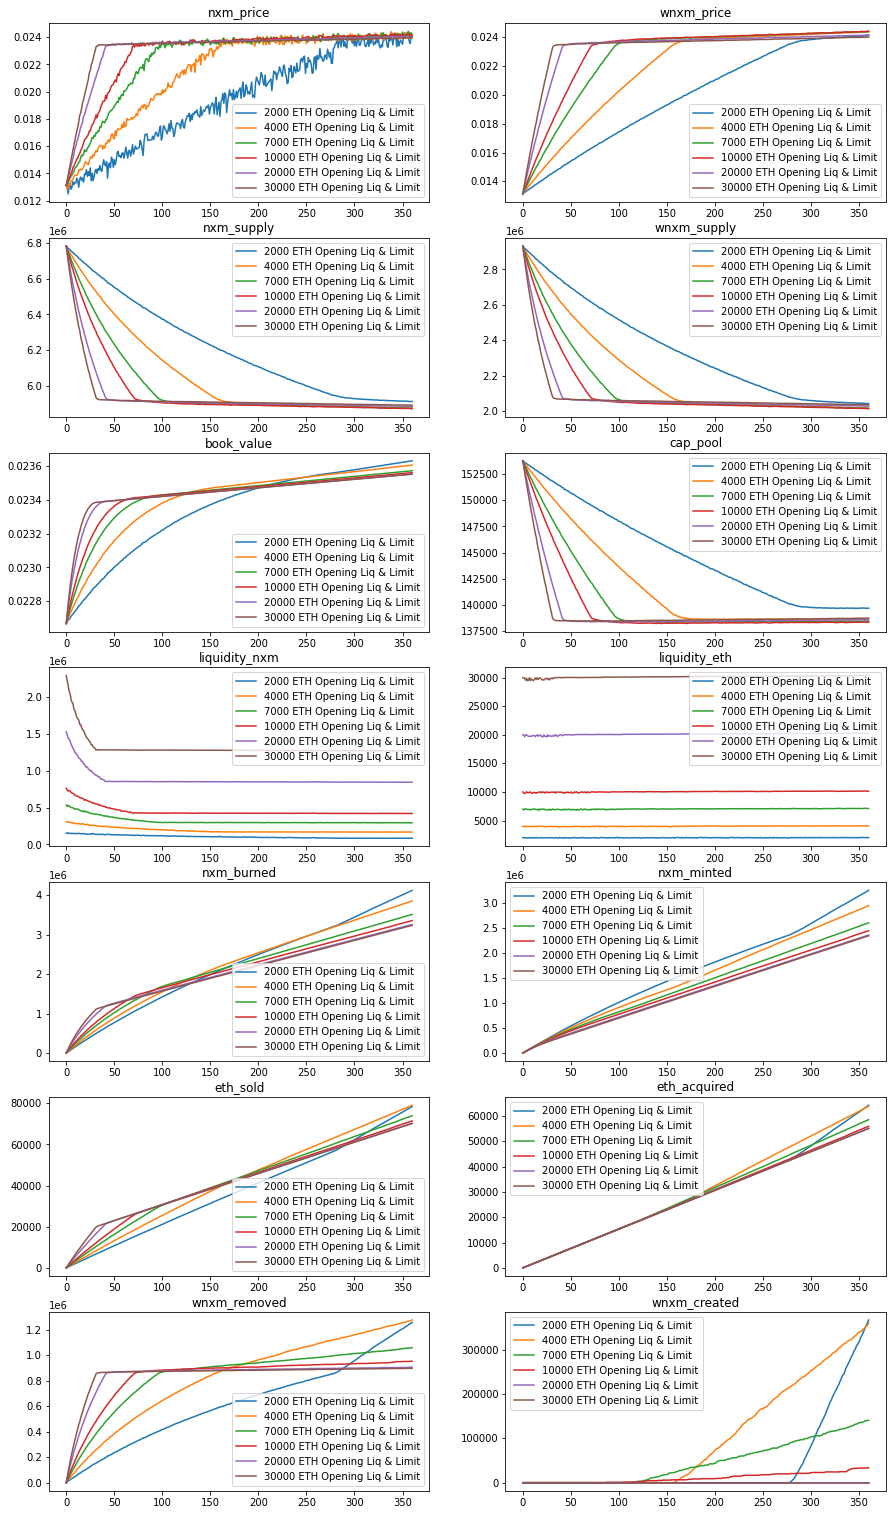

In [37]:
# model days
model_days = 360

# opening liquidity
# liquidity_eth = 4_000

# amount of USD it takes to make a 2% change in NXM price
wnxm_move_size = wnxm_movement_per_eth(two_perc_liq_usd=500_000)
# opening NXM price
wnxm_price = sys_params.wnxm_price_now

# number of entries & exits per day
lambda_entries = 10
lambda_exits = 10

# lognormal dist of size of entries and exits
entry_shape = 2
entry_loc = 0
entry_scale = 1
exit_shape = 2
exit_loc = 0
exit_scale = 1

# deterministic entry & exit size
det_sell_size = 15

# opening liquidity options
open_liq_range = [2_000, 4_000, 7_000, 10_000, 20_000, 30_000]

sims = [UniPoolDet(liquidity_eth=liq, wnxm_move_size=wnxm_move_size, wnxm_price=wnxm_price)
        for liq in open_liq_range]

for sim in sims:
    for i in range(model_days):
        try:
            sim.one_day_passes()
            days_run += 1
        except ZeroDivisionError:
            print('Something went to Zero!')
            break

# for i in range(len(sims)):
#     plt.plot(range(model_days+1), sims[i].nxm_price_prediction, label=f'{open_liq_range[i]*100}% free cap to Uni pool')
# plt.title('nxm_price')
# plt.legend(); 
        
#-----GRAPHS-----#
# Destructuring initialization
fig, axs = plt.subplots(7, 2, figsize=(15,27)) # axs is a (6,2) nd-array
# Subplot
for i in range(len(sims)):
    axs[0, 0].plot(range(model_days+1), sims[i].nxm_price_prediction, label=f'{open_liq_range[i]} ETH Opening Liq & Limit')
axs[0, 0].set_title('nxm_price')
axs[0, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[0, 1].plot(range(model_days+1), sims[i].wnxm_price_prediction, label=f'{open_liq_range[i]} ETH Opening Liq & Limit')
axs[0, 1].set_title('wnxm_price')
axs[0, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 0].plot(range(model_days+1), sims[i].nxm_supply_prediction, label=f'{open_liq_range[i]} ETH Opening Liq & Limit')
axs[1, 0].set_title('nxm_supply')
axs[1, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 1].plot(range(model_days+1), sims[i].wnxm_supply_prediction, label=f'{open_liq_range[i]} ETH Opening Liq & Limit')
axs[1, 1].set_title('wnxm_supply')
axs[1, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 0].plot(range(model_days+1), sims[i].book_value_prediction, label=f'{open_liq_range[i]} ETH Opening Liq & Limit')
axs[2, 0].set_title('book_value')
axs[2, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 1].plot(range(model_days+1), sims[i].cap_pool_prediction, label=f'{open_liq_range[i]} ETH Opening Liq & Limit')
axs[2, 1].set_title('cap_pool')
axs[2, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 0].plot(range(model_days+1), sims[i].liquidity_nxm_prediction, label=f'{open_liq_range[i]} ETH Opening Liq & Limit')
axs[3, 0].set_title('liquidity_nxm')
axs[3, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 1].plot(range(model_days+1), sims[i].liquidity_eth_prediction, label=f'{open_liq_range[i]} ETH Opening Liq & Limit')
axs[3, 1].set_title('liquidity_eth')
axs[3, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[4, 0].plot(range(model_days+1), sims[i].nxm_burned_prediction, label=f'{open_liq_range[i]} ETH Opening Liq & Limit')
axs[4, 0].set_title('nxm_burned')
axs[4, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[4, 1].plot(range(model_days+1), sims[i].nxm_minted_prediction, label=f'{open_liq_range[i]} ETH Opening Liq & Limit')
axs[4, 1].set_title('nxm_minted')
axs[4, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[5, 0].plot(range(model_days+1), sims[i].eth_sold_prediction, label=f'{open_liq_range[i]} ETH Opening Liq & Limit')
axs[5, 0].set_title('eth_sold')
axs[5, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[5, 1].plot(range(model_days+1), sims[i].eth_acquired_prediction, label=f'{open_liq_range[i]} ETH Opening Liq & Limit')
axs[5, 1].set_title('eth_acquired')
axs[5, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[6, 0].plot(range(model_days+1), sims[i].wnxm_removed_prediction, label=f'{open_liq_range[i]} ETH Opening Liq & Limit')
axs[6, 0].set_title('wnxm_removed')
axs[6, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[6, 1].plot(range(model_days+1), sims[i].wnxm_created_prediction, label=f'{open_liq_range[i]} ETH Opening Liq & Limit')
axs[6, 1].set_title('wnxm_created')
axs[6, 1].legend()

plt.show()